In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import lightkurve as lk
from scipy.optimize import minimize, fmin
from astropy.wcs import WCS
import astropy, astroquery

In [30]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)

In [31]:
data = eleanor.TargetData(star, height=15, width=15, do_pca=True, do_psf=False)

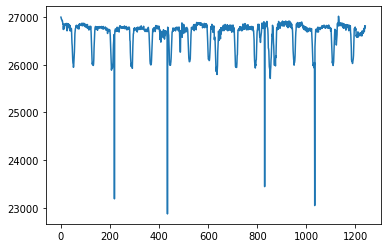

In [32]:
plt.plot(data.corr_flux)

In [34]:
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=13, 
    width=13, 
    do_pca=True, 
    do_psf=False,
    time_arr=time, 
    data_arr=tpfs, 
    err_arr=errs, 
    bkg_arr=bkgs, 
)
photometry_flux = sc.to_lightcurve().flux[sq][start:end]

In [37]:
data.psf_lightcurve(flux_arr=photometry_flux.value, model_name='Gaussian', bkg_mag_cutoff=10, verbose=True)

100%|██████████| 900/900 [04:23<00:00,  3.42it/s]


array([-0.05111304, -0.06015388,  0.67929934,  0.00190832,  0.72838697])

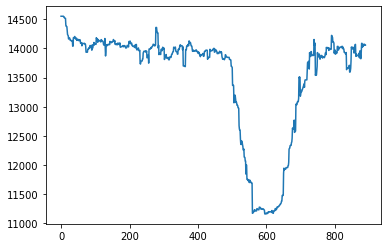

In [46]:
plt.plot(data.psf_flux[1,10:])

In [38]:
plt.plot(time, photometry_flux / np.max(photometry_flux), label='aperture photometry')
plt.plot(time[5:-5], (data.psf_flux[:end-start] / np.max(data.psf_flux[:end-start]))[5:-5] , label='psf fit')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (890,) and (0, 900)

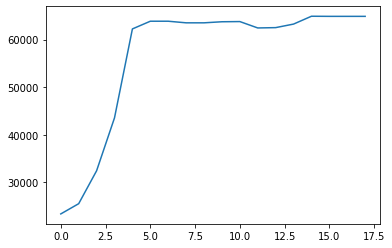

In [408]:
plt.plot(data.naive_psf_flux[2])

In [393]:
np.mean(data.naive_psf_flux, axis=1)

array([37794.44344415, 17324.13029534, 56493.04934151])